In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import mylibrary.nnlib as tnn
import mylibrary.dynamicnnlib as tdnn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

from types import MethodType

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

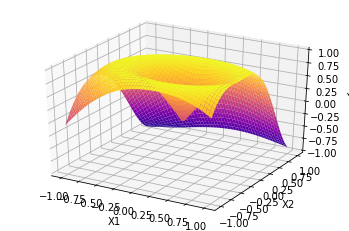

In [3]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

### Initial Network

In [4]:
optimizer = tnn.Adam(0.01)
dynet = tdnn.DynamicNN_Relu([2,3,1], optimizer)

In [5]:
total_new_neurons = 0

In [6]:
dynet

 2 == 3 == 1 ->
  \  / \  /
    1    1 

### Further Training/Adjustment

In [7]:
# dynet.gradient_multiplier = MethodType(gradient_multiplier_noisy, dynet)

In [93]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

try:
    for epoch in range(100000):
        yout = dynet.forward(xx)
        dy = yout - yy
        dx = dynet.backward(dy)

        dynet.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.0007380245658833753
100 Error =  0.0007364685653184371
200 Error =  0.0007350111660213354
300 Error =  0.0007337041056505929
400 Error =  0.0007324371008507594
500 Error =  0.0007311809856212463
600 Error =  0.0008558484233146633
700 Error =  0.0007289260669604351
800 Error =  0.0007277038135367464
900 Error =  0.0007290689721160483
1000 Error =  0.0007254334669300801
1100 Error =  0.0007270847045771218
1200 Error =  0.0007592391201108733
1300 Error =  0.0007230023675448849


TclError: invalid command name "pyimage109"

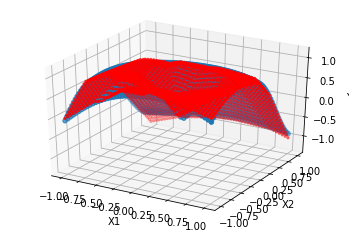

In [94]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
yout = dynet.forward(xx)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
fig.canvas.draw()

In [88]:
dynet_backup = copy.deepcopy(dynet)
# dynet = copy.deepcopy(dynet_backup)

In [89]:
dynet

 2 == 4 == 6 == 4 == 1 ->
  \  / \  / \  / \  /
    2    2    1    1 

## Add Neurons to all possible layers

In [71]:
neurons_added = dynet.add_neurons_to_all_possible_layers()
total_new_neurons += neurons_added
neurons_added

7

In [72]:
dynet

 2 == 5 == 6 == 4 == 1 ->
  \  / \  / \  / \  /
    2    2    2    2 

## Remove/Decay Shortcut connection (Residual Layer becomes new Layer)

In [64]:
dynet.start_decaying_removable_shortcut_connections(decay_steps=1000)

In [65]:
dynet.removable_layers

[0, 1]

In [66]:
dynet

 2 == 5 == 1 ->
  \  / \  /
    4    3 

## Compute Neuron Significance and decay less significant ones

In [90]:
dynet.compute_neuron_significance(xx)

In [91]:
dynet.significance

[array([[1.74120973, 0.55699508, 0.84221282, 0.73440461]]),
 array([[1.59951025, 0.57224225, 1.02507034, 0.6376164 , 0.2275761 ,
         0.15436798]]),
 array([[2.25627549, 0.41806836, 0.58716238, 0.19901015]])]

In [92]:
dynet.significance_res

[array([[9.00000000e+09, 1.47011961e-01]]),
 array([[9.00000000e+09, 1.94999813e-01]]),
 array([[9.e+09]]),
 array([[9.e+09]])]

In [81]:
# num_neurons_remove = total_new_neurons//2
num_neurons_remove = 3
num_neurons_remove

3

In [82]:
dynet.start_decaying_less_significant_neurons(num_neurons_remove, 99, steps=1000)

In [83]:
dynet.decay, dynet.decay_res

({0: array([4])}, {2: array([1]), 3: array([1])})

In [84]:
dynet

 2 == 5 == 6 == 4 == 1 ->
  \  / \  / \  / \  /
    2    2    2    2 

In [85]:
total_new_neurons = 0

In [40]:
def print_decay_weights(self):
    for li, neurons in self.decay.items():
        print('Outgoing straight weight')
        print(self.layers[li+1].weights[neurons])
        print('Outgoing residual weight')
        print(self.residuals_0[li+1].weights[neurons])
    for rli, neurons in self.decay_res.items():
        print('Outgoing residual weight -RES')
        print(self.residuals_1[rli].weights[neurons])

In [47]:
print_decay_weights(dynet)

Outgoing straight weight
[[0. 0. 0. 0.]]
Outgoing residual weight
[[0. 0. 0.]]
Outgoing straight weight
[[0.]]
Outgoing residual weight
[[0. 0. 0.]]
Outgoing residual weight -RES
[[0. 0. 0. 0.]]
Outgoing residual weight -RES
[[0.]]


In [42]:
dynet.neuron_decay_rate

{0: array([[-0., -0.,  0.,  0.]]), 1: array([[0.]])}

In [43]:
dynet.neuron_decay_rate2

{0: array([[-1.73693302e-04,  1.30460290e-05,  5.82157570e-04]]),
 1: array([[-2.91732021e-04, -3.32112014e-04, -1.27568576e-05]])}

In [44]:
dynet.neuron_res_decay_rate

{1: array([[-0.00023233, -0.        ,  0.00045947, -0.00011376]]),
 2: array([[0.000156]])}

In [45]:
print_decay_weights(dynet)

Outgoing straight weight
[[-0. -0.  0.  0.]]
Outgoing residual weight
[[-0.17367593  0.01304472  0.58209936]]
Outgoing straight weight
[[0.]]
Outgoing residual weight
[[-0.29170285 -0.33207881 -0.01275558]]
Outgoing residual weight -RES
[[-0.23230191 -0.          0.45942709 -0.11375325]]
Outgoing residual weight -RES
[[0.15598491]]


## Construction of NN for Spiral Dataset

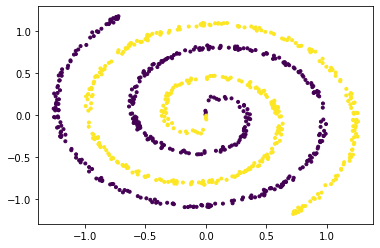

In [95]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = np.array(x), np.reshape(y, (-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.scatter(x1, x2, c=y, marker='.')
plt.show()

In [226]:
optimizer = tnn.Adam(0.001)
dynet = tdnn.DynamicNN_Relu([2,8,7,1], optimizer)
sigmoid = tnn.Sigmoid()

In [227]:
dynet

 2 == 8 == 7 == 1 ->
  \  / \  / \  /
    1    1    1 

In [225]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

try:
    for epoch in range(100000):
        yout = sigmoid.forward(dynet.forward(xx))
        
        dy = tnn.CrossEntropyBinary().del_loss(yout, yy)
        dx = dynet.backward(sigmoid.backward(dy))

        dynet.update()

        if epoch%100 == 0:
            error = tnn.CrossEntropyBinary().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()
            
#             out = (yout>0.5).reshape(-1)
            out = yout
            ax.scatter(x1, x2, c=out, marker='.')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e).startswith('invalid command name'):
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  1.0488596381436246
100 Error =  0.6914561016440111
200 Error =  0.6743995613313742
300 Error =  0.668297646709671
400 Error =  0.6662582704961886
500 Error =  0.6640369580996073
600 Error =  0.6619574849004166
700 Error =  0.65994958485627
800 Error =  0.6489219014178732
900 Error =  0.6279601828541066
1000 Error =  0.612468782604489
1100 Error =  0.5804048868998617
1200 Error =  0.5462766834270419
1300 Error =  0.5041732359005322
1400 Error =  0.40273176638654734
1500 Error =  0.3516335185564639
1600 Error =  0.34099122485162936
1700 Error =  0.33533984563993086
1800 Error =  0.33090118265690976
1900 Error =  0.32863198944968475
2000 Error =  0.32625839271497187
2100 Error =  0.32456421835287985
2200 Error =  0.32282979258606354
2300 Error =  0.32103948955433154
2400 Error =  0.3189863445709269
2500 Error =  0.31625167308812757
2600 Error =  0.313936338794907
2700 Error =  0.3127361409822039
2800 Error =  0.312068415256018
2900 Error =  0.3116611456578206
3000 Error =  0.31

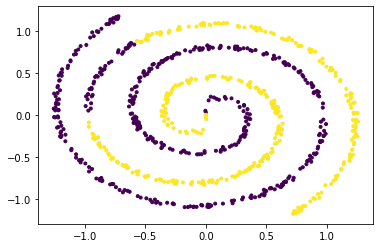

In [222]:
%matplotlib inline
yout = sigmoid.forward(dynet.forward(xx))
out = (yout>0.5).reshape(-1)

plt.scatter(x1, x2, c=out, marker='.')

In [212]:
dynet

 2 == 8 == 7 == 1 ->
  \  / \  / \  /
    1    1    1 

In [170]:
####

In [171]:
neurons_added = dynet.add_neurons_to_all_possible_layers()
neurons_added

7

In [135]:
####

In [136]:
dynet.start_decaying_removable_shortcut_connections(decay_steps=1000)
dynet.removable_layers

[0]

In [12]:
####

In [188]:
dynet.compute_neuron_significance(xx)
dynet.significance, dynet.significance_res

([array([[207.50039437,  99.66745499, 291.58381353, 154.7206461 ]]),
  array([[386.02305487,  46.96277024,  75.91270887,  83.60553066]]),
  array([[199.41902016, 110.96918738, 131.66715908]])],
 [array([[9.00000000e+09, 9.12282333e+01]]),
  array([[9.e+09]]),
  array([[9.00000000e+09, 1.09072735e+02, 3.93946359e+01]]),
  array([[9.e+09]])])

In [183]:
dynet.start_decaying_less_significant_neurons(1, 999, 1000)
dynet.decay, dynet.decay_res

({0: array([3])}, {})

In [189]:
dynet

 2 == 4 == 4 == 3 == 1 ->
  \  / \  / \  / \  /
    2    1    3    1 